In [1]:
import sys
import os
import time
import pickle
import glob

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from flow_features import *
from flow_analysis import *

In [2]:
import re

plot = True

def prepare_data(flows_path):
    # TODO: extract malicious flows metadata by reading directory names in flows_path
     
    # Read data
    benign_df = pd.read_parquet(f'{flows_path}/benign')
    malicious_df = pd.read_parquet(f'{flows_path}/malicious')

    # Label the data
    benign_df['label'] = 0  # BENIGN
    malicious_df['label'] = 1  # MALICIOUS

    # Combine datasets
    combined_df = pd.concat([benign_df, malicious_df], ignore_index=True)

    # Filter out flows where packets_count is less than 3
    combined_df = combined_df[combined_df['packets_count'] >= 3]

    # Separate features and labels
    labels = combined_df['label'].values
    features_df = combined_df.drop(['label'], axis=1)

    # Convert DataFrame to numpy array using flows_df_to_np
    features, metas = flows_df_to_np(features_df)
    
    return features, labels, metas

def evaluate_auroc(pred_probabilities, labels):
    all_positive = np.all(labels == 1)
    all_negative = np.all(labels == 0)
    if not all_positive and not all_negative:
        auroc = roc_auc_score(labels, pred_probabilities)
        print(f"AUROC: {auroc:.4f}")
        return auroc
    return None

def evaluate_metrics(pred_probabilities, labels, thresholds):
    all_positive = np.all(labels == 1)
    all_negative = np.all(labels == 0)

    if all_positive:
        results = {
            "Повнота": [],
        }
        for threshold in thresholds:
            predictions = (pred_probabilities >= threshold).astype(int)
            recall      = recall_score(labels, predictions)
            results["Повнота"].append(recall)
    elif all_negative:
        results = {
            "Хибнопозитивний рівень": [],
        }
        for threshold in thresholds:
            predictions = (pred_probabilities >= threshold).astype(int)
            cm          = confusion_matrix(labels, predictions)
            tn, fp, fn, tp = cm.ravel()
            fpr = fp / (fp + tn)
            results["Хибнопозитивний рівень"].append(fpr)
    else:
        results = {
            # "Влучність": [],
            "Точність": [],
            "Повнота": [],
            "Хибнопозитивний рівень": []
        }

        for threshold in thresholds:
            predictions = (pred_probabilities >= threshold).astype(int)
            accuracy    = accuracy_score(labels, predictions)
            precision   = precision_score(labels, predictions)
            recall      = recall_score(labels, predictions)
            cm          = confusion_matrix(labels, predictions)
            tn, fp, fn, tp = cm.ravel()
            fpr = fp / (fp + tn)
            
            # results["Влучність"].append(precision)
            results["Точність"].append(accuracy)
            results["Повнота"].append(recall)
            results["Хибнопозитивний рівень"].append(fpr)
    
    df = pd.DataFrame(results)
    df.insert(0, "Поріг", thresholds)  # Insert threshold as the first column
    display(df.round(4))  # Display formatted table with 3 decimal places in Jupyter Notebook
    
    return results
    
def plot_metrics_curves(thresholds, metric_results, info):
    plt.figure(figsize=(8, 5))
    
    markers = ['.', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']  # List of unique markers
    if len(metric_results) <= 5:
        colors = plt.colormaps['Set1'].colors 
    elif len(metric_results) <= 10:
        colors = plt.colormaps['tab10'].colors
    else:
        colors = plt.colormaps['tab20'].colors
    
    for i, (metric_name, values) in enumerate(metric_results.items()):
        marker = markers[i % len(markers)]  # Cycle through markers
        color = colors[i % len(colors)]
        plt.plot(thresholds, values, marker=marker, linestyle='-', label=metric_name, color=color)
    
    plt.xlabel("Поріг")
    plt.ylabel("Значення показника")
    plt.title(f"{info}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

def prepare_single_class_data(flows_path, label):
    df = pd.read_parquet(flows_path)
    df['label'] = label
    df = df[df['packets_count'] >= 3]
    labels = df['label'].values
    features_df = df.drop(['label'], axis=1)
    features, metas = flows_df_to_np(features_df)
    return features, labels, metas

def evaluate_subclass_recall(model, scaler, data_path, thresholds, label=1, is_keras=True, pca=None):
    print(f"Data path: {data_path}")
    subclasses = [os.path.basename(x) for x in glob.glob(f'{data_path}/*') if os.path.isdir(x)]
    recall_results = {}
    
    for subclass in subclasses:
        features, labels, meta = prepare_single_class_data(f'{data_path}/{subclass}', label=label)
        features = scaler.transform(features)
        if pca:
            features = pca.transform(features)
        if is_keras:
            prob = model.predict(features, verbose=0).ravel()
        else:
            prob = model.predict_proba(features)[:, 1]
        recall_results[subclass] = []
        
        for t in thresholds:
            recall = recall_score(labels, (prob >= t).astype(int))
            recall_results[subclass].append(recall)
    
    df = pd.DataFrame(recall_results)
    df.insert(0, "Threshold", thresholds)  # Insert threshold as the first column
    display(df.round(3))  # Display formatted table in Jupyter Notebook
    
    return recall_results

def plot_recall_curves(thresholds, recall_results, info):
    plt.figure(figsize=(8, 5))
    
    markers = ['.', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']  # List of unique markers
    if len(recall_results) <= 5:
        colors = plt.colormaps['Set1'].colors 
    elif len(recall_results) <= 10:
        colors = plt.colormaps['tab10'].colors
    else:
        colors = plt.colormaps['tab20'].colors

    for i, (subclass, recalls) in enumerate(recall_results.items()):
        marker = markers[i % len(markers)]  # Cycle through markers
        color = colors[i % len(colors)]
        plt.plot(thresholds, recalls, marker=marker, linestyle='-', label=subclass, color=color)
    
    plt.xlabel("Поріг")
    plt.ylabel("Повнота")
    plt.title(f"Повнота за типами зловмисного ПЗ\n{info}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

def evaluate(models, dataset, thresholds, plot=False, evaluate_per_subclass=False):
    for model_name in models:
        print(f"Model: {model_name}")
        is_keras = model_name.endswith('.keras')

        if is_keras:
            # Load the model from file
            model = tf.keras.models.load_model(f'./../artifacts/{model_name}')
        else:
            # Load the model from file
            with open(f'./../artifacts/{model_name}', 'rb') as f:
                model = pickle.load(f)

        # Extract directory name from model_name
        model_dir = os.path.basename(os.path.dirname(model_name))

        # Load the scaler from file
        with open(f'./../artifacts/{model_dir}/scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)

        # Prepare data
        test_features, test_labels, test_meta = prepare_data(f'./../flows/test/{dataset}')
        test_features = scaler.transform(test_features)

        contains_pca = re.match(r"(pca_\d+)_", os.path.basename(model_name))
        if contains_pca:
            pca_name = contains_pca.group(1)
            pca_path = f'./../artifacts/{model_dir}/{pca_name}.pkl'

            # Load the PCA from file
            with open(pca_path, 'rb') as f:
                pca = pickle.load(f)
            test_features = pca.transform(test_features)
        else:
            print("No PCA found")
            pca = None

        # Evaluate
        if is_keras:
            test_prob = model.predict(test_features, verbose=0).ravel()
        else:
            test_prob = model.predict_proba(test_features)[:, 1]

        if not evaluate_per_subclass:
            evaluate_auroc(test_prob, test_labels)
            test_result = evaluate_metrics(test_prob, test_labels, thresholds)

            plot_info = f"{model_name} - {dataset}"
            if plot:
                plot_metrics_curves(thresholds, test_result, plot_info)
        else:
            print("Recall per subclass")
            # NOTE: Section below requires reloading data
            recalls = evaluate_subclass_recall(model, scaler, f'./../flows/test/{dataset}/malicious', thresholds, is_keras=is_keras, pca=pca)
            plot_info = f"{os.path.splitext(model_name)[0]} - {dataset}"
            if plot:
                plot_recall_curves(thresholds, recalls, plot_info)

            extra_path = f'./../flows/test/{dataset}/malicious_extra'
            if os.path.exists(extra_path):
                recalls_extra = evaluate_subclass_recall(model, scaler, extra_path, thresholds, is_keras=is_keras, pca=pca)
                if plot:
                    plot_recall_curves(thresholds, recalls_extra, plot_info)

thresholds = [0.51, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.97]
print("Thresholds:", thresholds)

Thresholds: [0.51, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.97]


In [3]:
datasets = [
    "icsx-botnet-2014", "ctu-13", "ctu-custom"
]

models = [
    "icsx-botnet-2014/pca_12_log_reg.pkl", "icsx-botnet-2014/pca_12_rf_9.pkl",
    "icsx-botnet-2014/log_reg.pkl", "icsx-botnet-2014/rf_9.pkl",
    "icsx-botnet-2014/dnn_16_16_16.keras", "icsx-botnet-2014/dnn_24_24_24.keras",
    "icsx-botnet-2014/pca_12_dnn_16_16_16.keras", "icsx-botnet-2014/pca_12_dnn_24_24_24.keras"
]

for dataset in datasets:
    print("-----------------------------------------")
    print(f"  --->  Dataset: {dataset} <---")
    print("-----------------------------------------")

    evaluate(models, dataset, thresholds, plot=False, evaluate_per_subclass=False)

-----------------------------------------
  --->  Dataset: icsx-botnet-2014 <---
-----------------------------------------
Model: icsx-botnet-2014/pca_12_log_reg.pkl
AUROC: 0.7532


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.7193,0.6265,0.0092
1,0.60,0.7186,0.6245,0.0063
2,0.70,0.7163,0.6206,0.0041
3,0.80,0.6835,0.5759,0.0020
4,0.85,0.6796,0.5703,0.0011
5,0.90,0.6765,0.5661,0.0009
6,0.95,0.5380,0.3801,0.0004
7,0.97,0.5371,0.3788,0.0002


Model: icsx-botnet-2014/pca_12_rf_9.pkl
AUROC: 0.9165


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.5972,0.4603,0.0024
1,0.60,0.5882,0.4476,0.0008
2,0.70,0.5827,0.4400,0.0001
3,0.80,0.5744,0.4288,0.0001
4,0.85,0.5700,0.4229,0.0000
5,0.90,0.5660,0.4175,0.0000
6,0.95,0.5542,0.4017,0.0000
7,0.97,0.5526,0.3995,0.0000


Model: icsx-botnet-2014/log_reg.pkl
No PCA found
AUROC: 0.7565


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.7236,0.6322,0.0094
1,0.60,0.7216,0.6283,0.0058
2,0.70,0.7186,0.6237,0.0040
3,0.80,0.6879,0.5817,0.0017
4,0.85,0.6834,0.5755,0.0011
5,0.90,0.5769,0.4325,0.0009
6,0.95,0.5383,0.3805,0.0006
7,0.97,0.5363,0.3777,0.0002


Model: icsx-botnet-2014/rf_9.pkl
No PCA found
AUROC: 0.9563


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.6005,0.4642,0.0009
1,0.60,0.5886,0.4481,0.0008
2,0.70,0.5803,0.4370,0.0007
3,0.80,0.5724,0.4262,0.0003
4,0.85,0.5661,0.4177,0.0001
5,0.90,0.5612,0.4111,0.0000
6,0.95,0.5555,0.4034,0.0000
7,0.97,0.5548,0.4025,0.0000


Model: icsx-botnet-2014/dnn_16_16_16.keras
No PCA found
AUROC: 0.7239


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.6239,0.4969,0.0052
1,0.60,0.6152,0.4852,0.0046
2,0.70,0.6111,0.4795,0.0039
3,0.80,0.5997,0.4639,0.0031
4,0.85,0.5953,0.4574,0.0017
5,0.90,0.5913,0.4518,0.0011
6,0.95,0.5823,0.4395,0.0004
7,0.97,0.5715,0.4250,0.0004


Model: icsx-botnet-2014/dnn_24_24_24.keras
No PCA found
AUROC: 0.7384


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.6288,0.5034,0.0049
1,0.60,0.6123,0.4811,0.0043
2,0.70,0.6059,0.4722,0.0033
3,0.80,0.5919,0.4530,0.0021
4,0.85,0.5873,0.4466,0.0015
5,0.90,0.5843,0.4424,0.0011
6,0.95,0.5706,0.4239,0.0005
7,0.97,0.5675,0.4196,0.0002


Model: icsx-botnet-2014/pca_12_dnn_16_16_16.keras
AUROC: 0.7361


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.6264,0.5020,0.0101
1,0.60,0.6215,0.4950,0.0088
2,0.70,0.6178,0.4892,0.0063
3,0.80,0.6083,0.4755,0.0034
4,0.85,0.6007,0.4649,0.0023
5,0.90,0.5946,0.4565,0.0018
6,0.95,0.5819,0.4394,0.0014
7,0.97,0.5787,0.4348,0.0008


Model: icsx-botnet-2014/pca_12_dnn_24_24_24.keras
AUROC: 0.9006


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.6176,0.4890,0.0064
1,0.60,0.6141,0.4835,0.0040
2,0.70,0.6061,0.4721,0.0022
3,0.80,0.5949,0.4571,0.0020
4,0.85,0.5910,0.4518,0.0019
5,0.90,0.5845,0.4430,0.0018
6,0.95,0.5689,0.4219,0.0016
7,0.97,0.5668,0.4190,0.0012


-----------------------------------------
  --->  Dataset: ctu-13 <---
-----------------------------------------
Model: icsx-botnet-2014/pca_12_log_reg.pkl


,Поріг,Повнота
0,0.51,0.7952
1,0.60,0.7922
2,0.70,0.7858
3,0.80,0.7625
4,0.85,0.7552
5,0.90,0.7435
6,0.95,0.5782
7,0.97,0.5760


Model: icsx-botnet-2014/pca_12_rf_9.pkl


,Поріг,Повнота
0,0.51,0.7915
1,0.60,0.7689
2,0.70,0.7524
3,0.80,0.7231
4,0.85,0.7090
5,0.90,0.6990
6,0.95,0.6860
7,0.97,0.6816


Model: icsx-botnet-2014/log_reg.pkl
No PCA found


,Поріг,Повнота
0,0.51,0.8034
1,0.60,0.7986
2,0.70,0.7920
3,0.80,0.7859
4,0.85,0.7672
5,0.90,0.6807
6,0.95,0.5815
7,0.97,0.5769


Model: icsx-botnet-2014/rf_9.pkl
No PCA found


,Поріг,Повнота
0,0.51,0.8450
1,0.60,0.8181
2,0.70,0.7880
3,0.80,0.7607
4,0.85,0.7342
5,0.90,0.7084
6,0.95,0.6898
7,0.97,0.6855


Model: icsx-botnet-2014/dnn_16_16_16.keras
No PCA found


,Поріг,Повнота
0,0.51,0.8170
1,0.60,0.8046
2,0.70,0.7924
3,0.80,0.7542
4,0.85,0.7418
5,0.90,0.7327
6,0.95,0.7117
7,0.97,0.6995


Model: icsx-botnet-2014/dnn_24_24_24.keras
No PCA found


,Поріг,Повнота
0,0.51,0.8147
1,0.60,0.7857
2,0.70,0.7690
3,0.80,0.7504
4,0.85,0.7386
5,0.90,0.7207
6,0.95,0.6945
7,0.97,0.6799


Model: icsx-botnet-2014/pca_12_dnn_16_16_16.keras


,Поріг,Повнота
0,0.51,0.8518
1,0.60,0.8424
2,0.70,0.8267
3,0.80,0.7885
4,0.85,0.7637
5,0.90,0.7382
6,0.95,0.7134
7,0.97,0.6972


Model: icsx-botnet-2014/pca_12_dnn_24_24_24.keras


,Поріг,Повнота
0,0.51,0.8208
1,0.60,0.8054
2,0.70,0.7775
3,0.80,0.7523
4,0.85,0.7354
5,0.90,0.7180
6,0.95,0.6956
7,0.97,0.6837


-----------------------------------------
  --->  Dataset: ctu-custom <---
-----------------------------------------
Model: icsx-botnet-2014/pca_12_log_reg.pkl
AUROC: 0.8233


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.0996,0.0494,0.0036
1,0.60,0.0683,0.0164,0.0026
2,0.70,0.0648,0.0126,0.0015
3,0.80,0.0646,0.0123,0.0013
4,0.85,0.0617,0.0092,0.0010
5,0.90,0.0584,0.0057,0.0006
6,0.95,0.0583,0.0057,0.0005
7,0.97,0.0574,0.0047,0.0000


Model: icsx-botnet-2014/pca_12_rf_9.pkl
AUROC: 0.2617


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.0823,0.0312,0.0035
1,0.60,0.0582,0.0055,0.0003
2,0.70,0.0582,0.0055,0.0000
3,0.80,0.0582,0.0055,0.0000
4,0.85,0.0582,0.0055,0.0000
5,0.90,0.0578,0.0051,0.0000
6,0.95,0.0534,0.0005,0.0000
7,0.97,0.0533,0.0003,0.0000


Model: icsx-botnet-2014/log_reg.pkl
No PCA found
AUROC: 0.7122


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.0959,0.0573,0.2148
1,0.60,0.0639,0.0235,0.2124
2,0.70,0.0602,0.0193,0.2092
3,0.80,0.0578,0.0167,0.2073
4,0.85,0.0570,0.0157,0.2061
5,0.90,0.0549,0.0135,0.2043
6,0.95,0.0528,0.0111,0.2024
7,0.97,0.0529,0.0111,0.1995


Model: icsx-botnet-2014/rf_9.pkl
No PCA found
AUROC: 0.5462


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.0756,0.0240,0.0018
1,0.60,0.0682,0.0161,0.0006
2,0.70,0.0615,0.0090,0.0001
3,0.80,0.0554,0.0026,0.0000
4,0.85,0.0539,0.0009,0.0000
5,0.90,0.0531,0.0002,0.0000
6,0.95,0.0530,0.0000,0.0000
7,0.97,0.0530,0.0000,0.0000


Model: icsx-botnet-2014/dnn_16_16_16.keras
No PCA found
AUROC: 0.7010


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.0861,0.0443,0.1670
1,0.60,0.0558,0.0123,0.1662
2,0.70,0.0558,0.0122,0.1646
3,0.80,0.0559,0.0122,0.1627
4,0.85,0.0559,0.0122,0.1621
5,0.90,0.0554,0.0115,0.1604
6,0.95,0.0554,0.0115,0.1598
7,0.97,0.0554,0.0115,0.1594


Model: icsx-botnet-2014/dnn_24_24_24.keras
No PCA found
AUROC: 0.2307


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.0333,0.0100,0.5506
1,0.60,0.0334,0.0099,0.5471
2,0.70,0.0336,0.0099,0.5426
3,0.80,0.0339,0.0099,0.5380
4,0.85,0.0340,0.0099,0.5351
5,0.90,0.0342,0.0099,0.5316
6,0.95,0.0345,0.0099,0.5256
7,0.97,0.0346,0.0098,0.5217


Model: icsx-botnet-2014/pca_12_dnn_16_16_16.keras
AUROC: 0.1622


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.0986,0.0492,0.0178
1,0.60,0.0969,0.0472,0.0144
2,0.70,0.0587,0.0066,0.0106
3,0.80,0.0588,0.0066,0.0087
4,0.85,0.0588,0.0066,0.0081
5,0.90,0.0585,0.0063,0.0075
6,0.95,0.0586,0.0062,0.0053
7,0.97,0.0584,0.0059,0.0029


Model: icsx-botnet-2014/pca_12_dnn_24_24_24.keras
AUROC: 0.7913


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.0995,0.0544,0.0953
1,0.60,0.0995,0.0542,0.0896
2,0.70,0.0655,0.0179,0.0829
3,0.80,0.0655,0.0169,0.0656
4,0.85,0.0656,0.0167,0.0604
5,0.90,0.0655,0.0163,0.0558
6,0.95,0.0655,0.0162,0.0531
7,0.97,0.0656,0.0159,0.0465


In [4]:
datasets = [
    "icsx-ctu-extended"
]

models = [
    "icsx-botnet-2014/pca_12_log_reg.pkl", "icsx-botnet-2014/pca_12_rf_9.pkl",
    "icsx-botnet-2014/log_reg.pkl", "icsx-botnet-2014/rf_9.pkl",
    "icsx-botnet-2014/dnn_16_16_16.keras", "icsx-botnet-2014/dnn_24_24_24.keras",
    "icsx-botnet-2014/pca_12_dnn_16_16_16.keras", "icsx-botnet-2014/pca_12_dnn_24_24_24.keras"
]

for dataset in datasets:
    print("-----------------------------------------")
    print(f"  --->  Dataset: {dataset} <---")
    print("-----------------------------------------")

    evaluate(models, dataset, thresholds, plot=False, evaluate_per_subclass=False)

-----------------------------------------
  --->  Dataset: icsx-ctu-extended <---
-----------------------------------------
Model: icsx-botnet-2014/pca_12_log_reg.pkl
AUROC: 0.6705


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.3820,0.3327,0.0069
1,0.60,0.3631,0.3122,0.0048
2,0.70,0.3591,0.3077,0.0031
3,0.80,0.3474,0.2950,0.0017
4,0.85,0.3432,0.2904,0.0011
5,0.90,0.3378,0.2846,0.0008
6,0.95,0.2722,0.2136,0.0005
7,0.97,0.2710,0.2123,0.0001


Model: icsx-botnet-2014/pca_12_rf_9.pkl
AUROC: 0.7599


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.3500,0.2979,0.0028
1,0.60,0.3288,0.2748,0.0006
2,0.70,0.3237,0.2693,0.0001
3,0.80,0.3149,0.2597,0.0000
4,0.85,0.3106,0.2551,0.0000
5,0.90,0.3072,0.2514,0.0000
6,0.95,0.2994,0.2429,0.0000
7,0.97,0.2979,0.2413,0.0000


Model: icsx-botnet-2014/log_reg.pkl
No PCA found
AUROC: 0.6413


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.3827,0.3404,0.0933
1,0.60,0.3627,0.3186,0.0902
2,0.70,0.3584,0.3137,0.0878
3,0.80,0.3502,0.3047,0.0857
4,0.85,0.3442,0.2982,0.0849
5,0.90,0.3028,0.2534,0.0840
6,0.95,0.2699,0.2178,0.0830
7,0.97,0.2685,0.2161,0.0816


Model: icsx-botnet-2014/rf_9.pkl
No PCA found
AUROC: 0.8350


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.3602,0.3087,0.0013
1,0.60,0.3471,0.2945,0.0007
2,0.70,0.3342,0.2806,0.0004
3,0.80,0.3225,0.2679,0.0002
4,0.85,0.3138,0.2585,0.0001
5,0.90,0.3060,0.2501,0.0000
6,0.95,0.3003,0.2439,0.0000
7,0.97,0.2991,0.2426,0.0000


Model: icsx-botnet-2014/dnn_16_16_16.keras
No PCA found
AUROC: 0.6089


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.3632,0.3176,0.0713
1,0.60,0.3412,0.2938,0.0706
2,0.70,0.3374,0.2896,0.0696
3,0.80,0.3258,0.2770,0.0683
4,0.85,0.3220,0.2728,0.0672
5,0.90,0.3187,0.2691,0.0662
6,0.95,0.3118,0.2617,0.0655
7,0.97,0.3069,0.2563,0.0653


Model: icsx-botnet-2014/dnn_24_24_24.keras
No PCA found
AUROC: 0.4126


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.3331,0.2977,0.2278
1,0.60,0.3230,0.2867,0.2260
2,0.70,0.3178,0.2809,0.2236
3,0.80,0.3109,0.2731,0.2211
4,0.85,0.3072,0.2690,0.2195
5,0.90,0.3023,0.2636,0.2179
6,0.95,0.2935,0.2539,0.2150
7,0.97,0.2893,0.2492,0.2133


Model: icsx-botnet-2014/pca_12_dnn_16_16_16.keras
AUROC: 0.4768


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.3796,0.3307,0.0133
1,0.60,0.3754,0.3260,0.0111
2,0.70,0.3488,0.2970,0.0080
3,0.80,0.3376,0.2847,0.0056
4,0.85,0.3301,0.2765,0.0046
5,0.90,0.3224,0.2682,0.0041
6,0.95,0.3140,0.2590,0.0030
7,0.97,0.3093,0.2538,0.0017


Model: icsx-botnet-2014/pca_12_dnn_24_24_24.keras
AUROC: 0.8012


,Поріг,Точність,Повнота,Хибнопозитивний рівень
0,0.51,0.3708,0.3235,0.0427
1,0.60,0.3663,0.3184,0.0390
2,0.70,0.3383,0.2879,0.0352
3,0.80,0.3300,0.2783,0.0280
4,0.85,0.3252,0.2729,0.0258
5,0.90,0.3196,0.2667,0.0239
6,0.95,0.3113,0.2576,0.0227
7,0.97,0.3080,0.2538,0.0197


-----------------------------------------
  --->  Dataset: icsx-botnet-2014 <---
-----------------------------------------
Model: icsx-botnet-2014/pca_12_log_reg.pkl
Recall per subclass
Data path: ./../flows/test/icsx-botnet-2014/malicious


,Threshold,IRC,Menti,Murlo,Neris,RBot,Sogou,Virut,Weasel
0,0.51,0.152,0.917,0.214,0.756,0.039,0.275,0.911,0.138
1,0.60,0.124,0.910,0.214,0.750,0.039,0.250,0.910,0.138
2,0.70,0.008,0.908,0.211,0.744,0.039,0.225,0.906,0.137
3,0.80,0.008,0.901,0.171,0.735,0.039,0.175,0.900,0.003
4,0.85,0.008,0.898,0.074,0.731,0.039,0.125,0.897,0.003
5,0.90,0.008,0.897,0.051,0.731,0.039,0.075,0.889,0.003
6,0.95,0.008,0.264,0.041,0.056,0.032,0.000,0.875,0.000
7,0.97,0.008,0.262,0.037,0.056,0.032,0.000,0.872,0.000


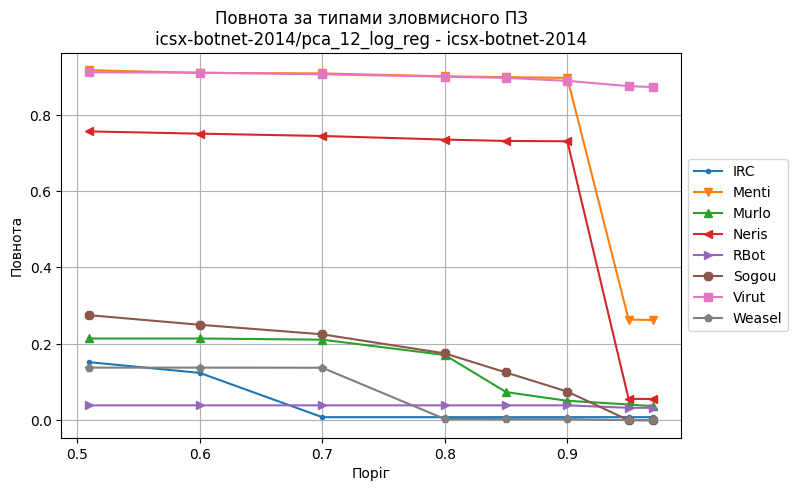

Data path: ./../flows/test/icsx-botnet-2014/malicious_extra


,Threshold,Black_hole,TBot,Zero_access,Zeus
0,0.51,0.062,0.025,0.0,0.239
1,0.60,0.062,0.014,0.0,0.103
2,0.70,0.053,0.010,0.0,0.070
3,0.80,0.044,0.010,0.0,0.023
4,0.85,0.044,0.000,0.0,0.023
5,0.90,0.044,0.000,0.0,0.023
6,0.95,0.009,0.000,0.0,0.000
7,0.97,0.009,0.000,0.0,0.000


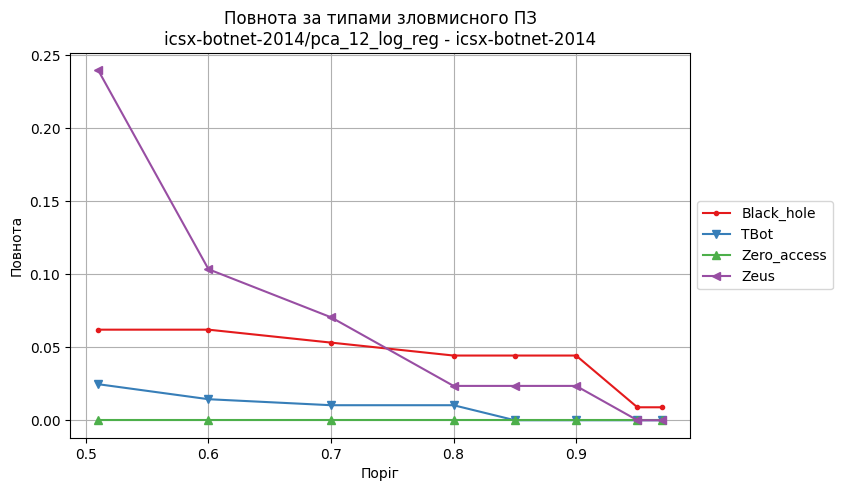

Model: icsx-botnet-2014/pca_12_rf_9.pkl
Recall per subclass
Data path: ./../flows/test/icsx-botnet-2014/malicious


,Threshold,IRC,Menti,Murlo,Neris,RBot,Sogou,Virut,Weasel
0,0.51,1.000,0.932,0.286,0.103,0.961,0.325,0.956,0.001
1,0.60,1.000,0.926,0.283,0.071,0.948,0.125,0.945,0.001
2,0.70,0.980,0.925,0.258,0.061,0.948,0.075,0.934,0.001
3,0.80,0.912,0.924,0.256,0.057,0.942,0.075,0.910,0.000
4,0.85,0.780,0.919,0.225,0.055,0.942,0.075,0.901,0.000
5,0.90,0.496,0.906,0.199,0.049,0.942,0.075,0.897,0.000
6,0.95,0.432,0.905,0.103,0.001,0.929,0.075,0.893,0.000
7,0.97,0.316,0.904,0.092,0.000,0.929,0.075,0.890,0.000


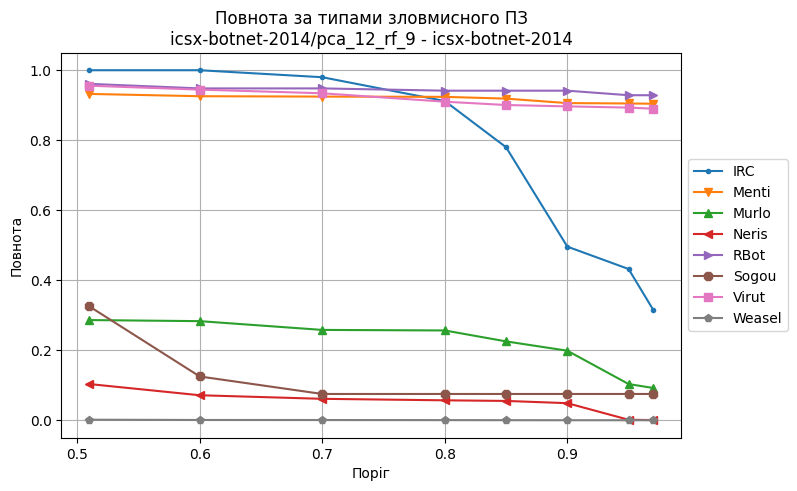

Data path: ./../flows/test/icsx-botnet-2014/malicious_extra


,Threshold,Black_hole,TBot,Zero_access,Zeus
0,0.51,0.124,0.016,0.0,0.117
1,0.60,0.000,0.014,0.0,0.085
2,0.70,0.000,0.000,0.0,0.005
3,0.80,0.000,0.000,0.0,0.000
4,0.85,0.000,0.000,0.0,0.000
5,0.90,0.000,0.000,0.0,0.000
6,0.95,0.000,0.000,0.0,0.000
7,0.97,0.000,0.000,0.0,0.000


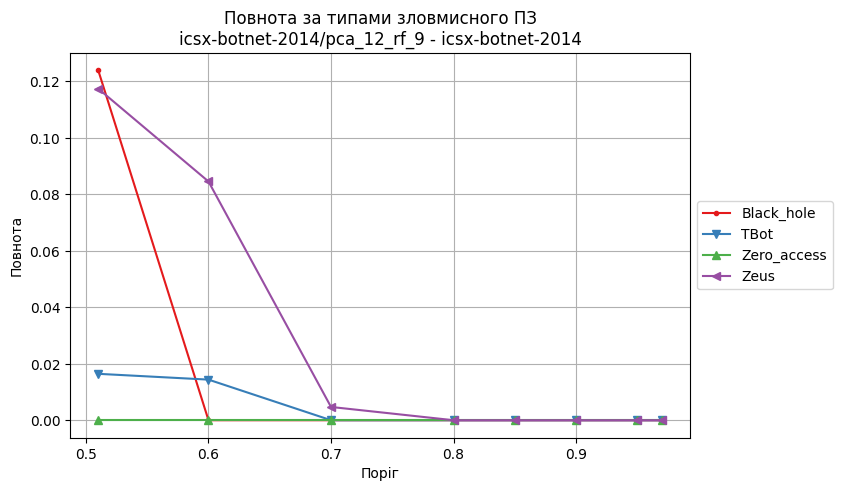

Model: icsx-botnet-2014/pca_12_dnn_16_16_16.keras
Recall per subclass
Data path: ./../flows/test/icsx-botnet-2014/malicious


,Threshold,IRC,Menti,Murlo,Neris,RBot,Sogou,Virut,Weasel
0,0.51,1.000,0.996,0.994,0.105,0.942,0.825,0.990,0.009
1,0.60,1.000,0.996,0.992,0.081,0.929,0.625,0.988,0.008
2,0.70,1.000,0.996,0.973,0.073,0.929,0.550,0.980,0.008
3,0.80,0.992,0.945,0.890,0.070,0.916,0.325,0.959,0.008
4,0.85,0.992,0.944,0.890,0.066,0.019,0.250,0.944,0.001
5,0.90,0.992,0.944,0.886,0.065,0.019,0.225,0.925,0.001
6,0.95,0.908,0.944,0.503,0.063,0.019,0.175,0.915,0.001
7,0.97,0.604,0.944,0.501,0.062,0.019,0.150,0.907,0.001


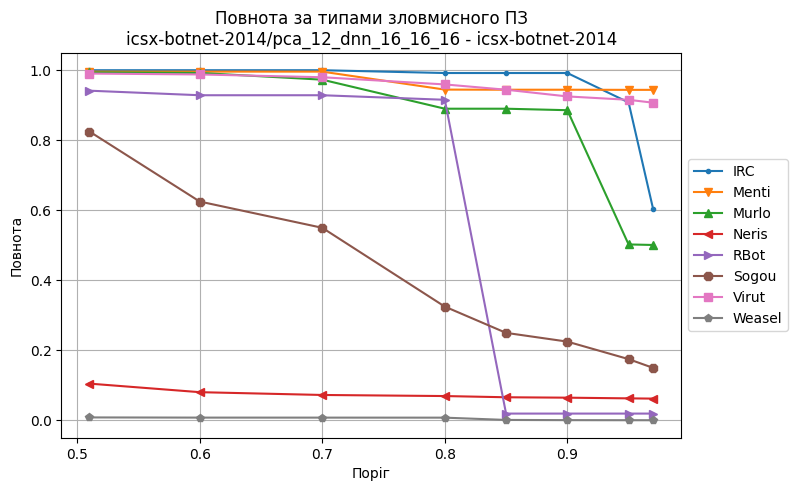

Data path: ./../flows/test/icsx-botnet-2014/malicious_extra


,Threshold,Black_hole,TBot,Zero_access,Zeus
0,0.51,0.0,0.021,0.0,0.108
1,0.60,0.0,0.021,0.0,0.103
2,0.70,0.0,0.006,0.0,0.070
3,0.80,0.0,0.004,0.0,0.009
4,0.85,0.0,0.004,0.0,0.009
5,0.90,0.0,0.004,0.0,0.009
6,0.95,0.0,0.000,0.0,0.005
7,0.97,0.0,0.000,0.0,0.005


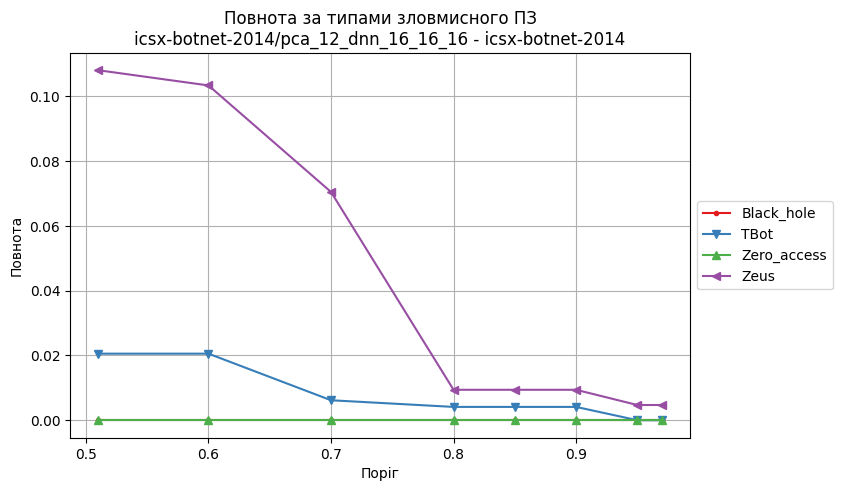

Model: icsx-botnet-2014/pca_12_dnn_24_24_24.keras
Recall per subclass
Data path: ./../flows/test/icsx-botnet-2014/malicious


,Threshold,IRC,Menti,Murlo,Neris,RBot,Sogou,Virut,Weasel
0,0.51,1.000,0.933,0.952,0.076,0.942,0.675,0.979,0.015
1,0.60,1.000,0.933,0.950,0.075,0.942,0.575,0.967,0.015
2,0.70,1.000,0.916,0.890,0.073,0.338,0.500,0.949,0.014
3,0.80,1.000,0.915,0.638,0.067,0.032,0.425,0.940,0.010
4,0.85,1.000,0.915,0.595,0.064,0.032,0.400,0.933,0.010
5,0.90,1.000,0.914,0.502,0.061,0.032,0.300,0.921,0.009
6,0.95,0.988,0.906,0.128,0.060,0.032,0.225,0.905,0.003
7,0.97,0.964,0.906,0.128,0.059,0.032,0.225,0.898,0.003


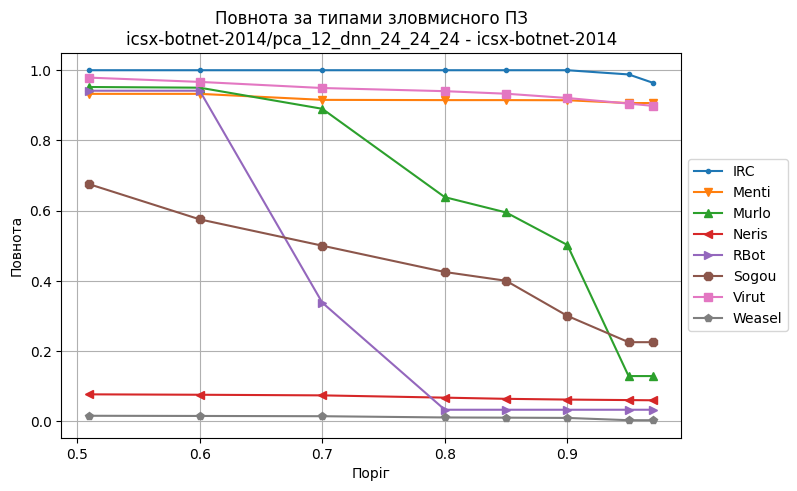

Data path: ./../flows/test/icsx-botnet-2014/malicious_extra


,Threshold,Black_hole,TBot,Zero_access,Zeus
0,0.51,0.009,0.027,0.0,0.047
1,0.60,0.009,0.027,0.0,0.042
2,0.70,0.009,0.012,0.0,0.038
3,0.80,0.009,0.012,0.0,0.038
4,0.85,0.009,0.010,0.0,0.033
5,0.90,0.009,0.010,0.0,0.023
6,0.95,0.009,0.004,0.0,0.014
7,0.97,0.009,0.004,0.0,0.014


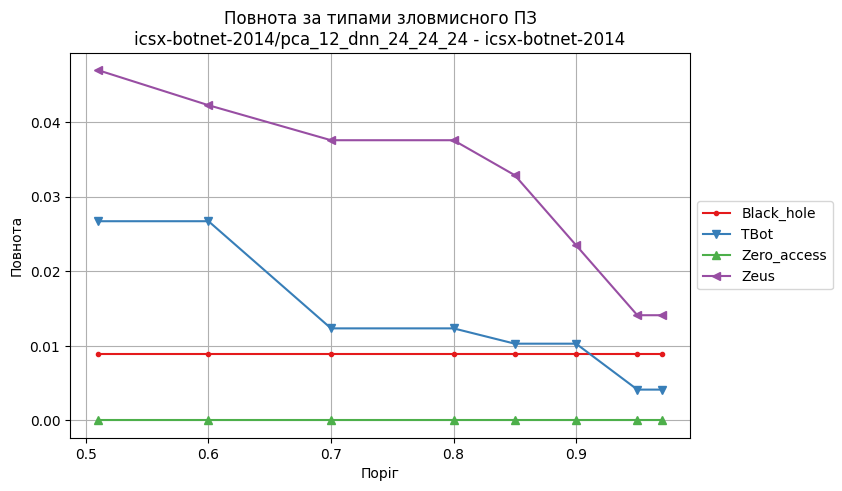

-----------------------------------------
  --->  Dataset: ctu-13 <---
-----------------------------------------
Model: icsx-botnet-2014/pca_12_log_reg.pkl
Recall per subclass
Data path: ./../flows/test/ctu-13/malicious


,Threshold,DonBot,Murlo,Neris,NSIS.ay,RBot,Sogou,Virut
0,0.51,0.917,0.214,0.736,0.219,0.884,0.275,0.901
1,0.60,0.910,0.214,0.732,0.176,0.882,0.250,0.901
2,0.70,0.908,0.211,0.722,0.151,0.881,0.225,0.896
3,0.80,0.901,0.171,0.707,0.086,0.819,0.175,0.890
4,0.85,0.898,0.074,0.698,0.057,0.819,0.125,0.887
5,0.90,0.897,0.051,0.681,0.030,0.819,0.075,0.879
6,0.95,0.264,0.041,0.403,0.016,0.819,0.000,0.863
7,0.97,0.262,0.037,0.403,0.011,0.812,0.000,0.861


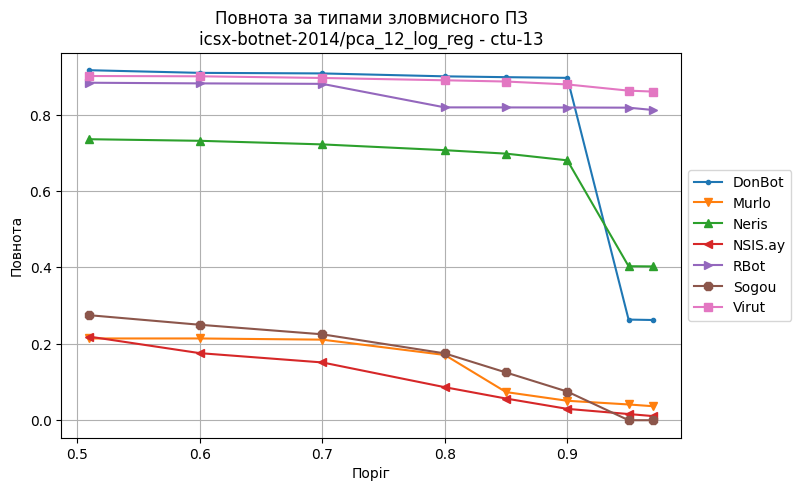

Model: icsx-botnet-2014/pca_12_rf_9.pkl
Recall per subclass
Data path: ./../flows/test/ctu-13/malicious


,Threshold,DonBot,Murlo,Neris,NSIS.ay,RBot,Sogou,Virut
0,0.51,0.932,0.286,0.664,0.176,0.999,0.325,0.950
1,0.60,0.926,0.283,0.628,0.081,0.997,0.125,0.937
2,0.70,0.925,0.258,0.604,0.014,0.995,0.075,0.926
3,0.80,0.924,0.257,0.560,0.005,0.994,0.075,0.902
4,0.85,0.919,0.225,0.540,0.005,0.993,0.075,0.892
5,0.90,0.906,0.199,0.525,0.000,0.991,0.075,0.887
6,0.95,0.905,0.103,0.508,0.000,0.985,0.075,0.884
7,0.97,0.904,0.092,0.505,0.000,0.974,0.075,0.881


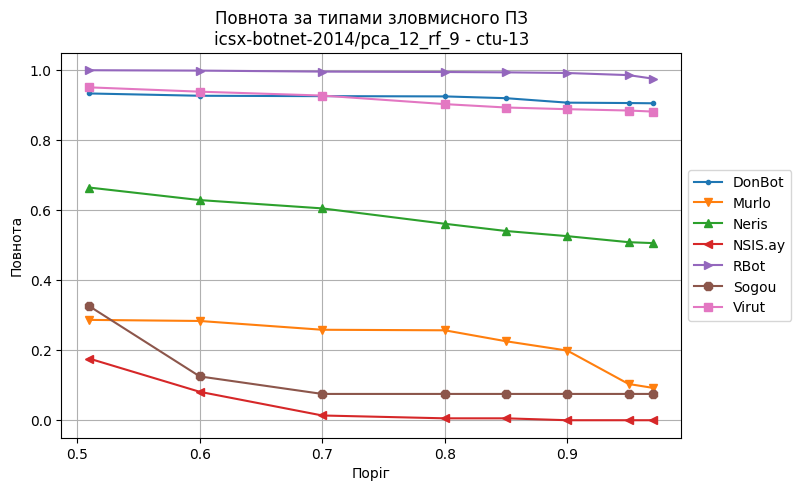

Model: icsx-botnet-2014/pca_12_dnn_16_16_16.keras
Recall per subclass
Data path: ./../flows/test/ctu-13/malicious


,Threshold,DonBot,Murlo,Neris,NSIS.ay,RBot,Sogou,Virut
0,0.51,0.996,0.994,0.765,0.716,0.914,0.825,0.989
1,0.60,0.996,0.992,0.750,0.686,0.913,0.625,0.986
2,0.70,0.996,0.973,0.725,0.635,0.913,0.550,0.977
3,0.80,0.945,0.890,0.675,0.405,0.896,0.325,0.955
4,0.85,0.944,0.890,0.641,0.270,0.885,0.250,0.938
5,0.90,0.944,0.886,0.604,0.181,0.885,0.225,0.916
6,0.95,0.944,0.502,0.574,0.111,0.883,0.175,0.906
7,0.97,0.944,0.501,0.548,0.076,0.882,0.150,0.898


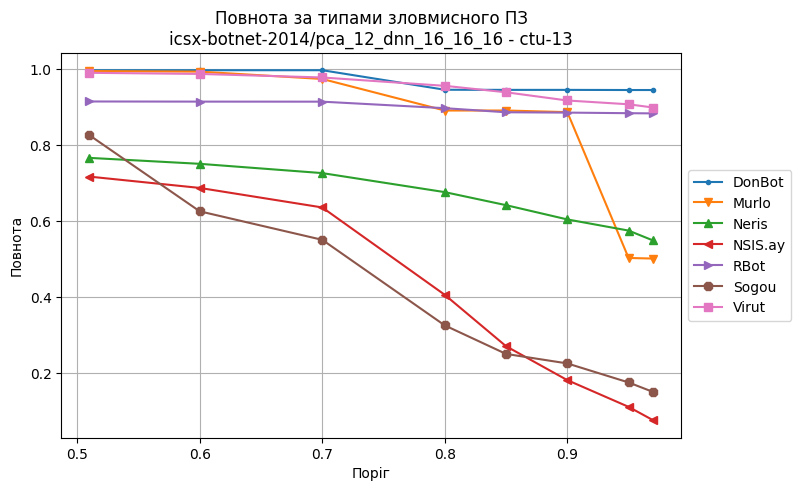

Model: icsx-botnet-2014/pca_12_dnn_24_24_24.keras
Recall per subclass
Data path: ./../flows/test/ctu-13/malicious


,Threshold,DonBot,Murlo,Neris,NSIS.ay,RBot,Sogou,Virut
0,0.51,0.933,0.952,0.718,0.551,0.914,0.675,0.975
1,0.60,0.933,0.950,0.696,0.408,0.913,0.575,0.962
2,0.70,0.916,0.890,0.663,0.297,0.891,0.500,0.944
3,0.80,0.915,0.638,0.631,0.208,0.885,0.425,0.933
4,0.85,0.915,0.595,0.605,0.170,0.885,0.400,0.925
5,0.90,0.914,0.502,0.581,0.122,0.884,0.300,0.913
6,0.95,0.906,0.128,0.558,0.081,0.883,0.225,0.896
7,0.97,0.906,0.128,0.542,0.068,0.876,0.225,0.889


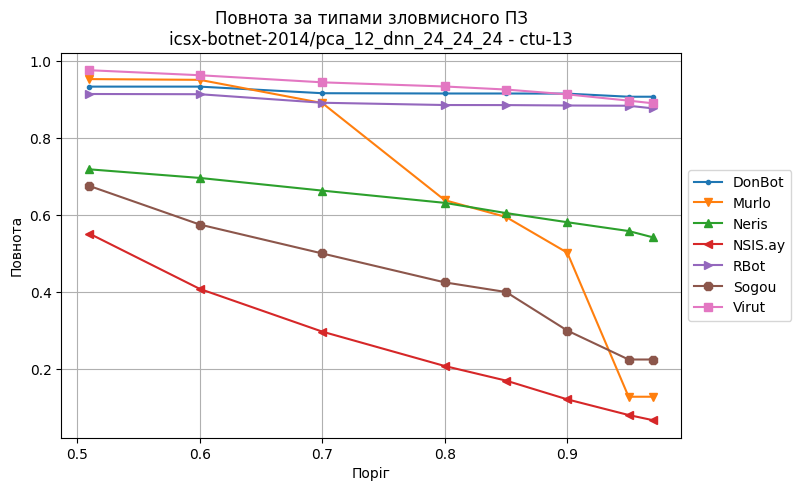

-----------------------------------------
  --->  Dataset: ctu-custom <---
-----------------------------------------
Model: icsx-botnet-2014/pca_12_log_reg.pkl
Recall per subclass
Data path: ./../flows/test/ctu-custom/malicious


,Threshold,Emotet,Kazy,TrickBot,WannaCry,Zeus
0,0.51,0.0,0.453,0.074,0.005,0.0
1,0.60,0.0,0.438,0.002,0.001,0.0
2,0.70,0.0,0.330,0.002,0.001,0.0
3,0.80,0.0,0.322,0.002,0.001,0.0
4,0.85,0.0,0.235,0.002,0.001,0.0
5,0.90,0.0,0.135,0.002,0.001,0.0
6,0.95,0.0,0.134,0.002,0.000,0.0
7,0.97,0.0,0.134,0.000,0.000,0.0


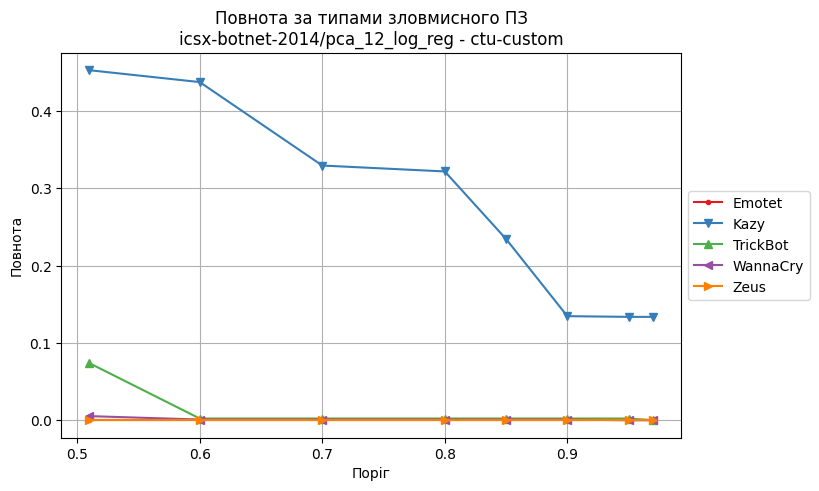

Model: icsx-botnet-2014/pca_12_rf_9.pkl
Recall per subclass
Data path: ./../flows/test/ctu-custom/malicious


,Threshold,Emotet,Kazy,TrickBot,WannaCry,Zeus
0,0.51,0.0,0.158,0.05,0.213,0.0
1,0.60,0.0,0.157,0.00,0.000,0.0
2,0.70,0.0,0.156,0.00,0.000,0.0
3,0.80,0.0,0.156,0.00,0.000,0.0
4,0.85,0.0,0.156,0.00,0.000,0.0
5,0.90,0.0,0.145,0.00,0.000,0.0
6,0.95,0.0,0.014,0.00,0.000,0.0
7,0.97,0.0,0.010,0.00,0.000,0.0


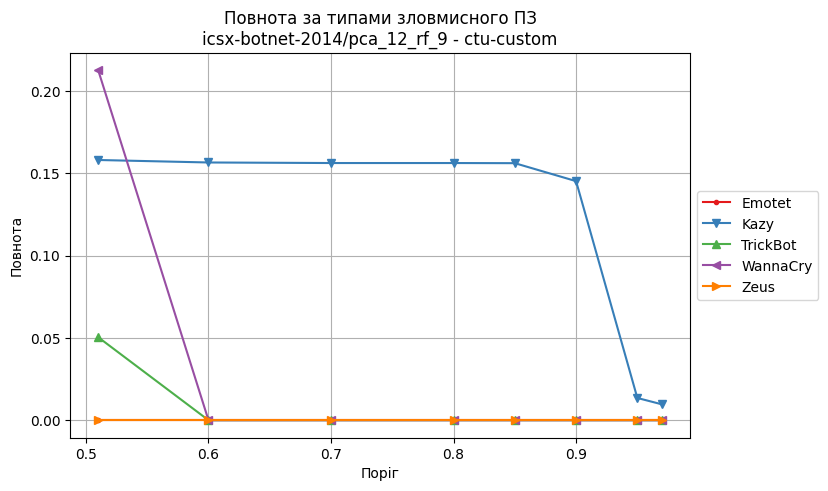

Model: icsx-botnet-2014/pca_12_dnn_16_16_16.keras
Recall per subclass
Data path: ./../flows/test/ctu-custom/malicious


,Threshold,Emotet,Kazy,TrickBot,WannaCry,Zeus
0,0.51,0.096,0.172,0.002,0.002,0.0
1,0.60,0.092,0.164,0.002,0.002,0.0
2,0.70,0.000,0.159,0.002,0.002,0.0
3,0.80,0.000,0.159,0.002,0.002,0.0
4,0.85,0.000,0.159,0.002,0.002,0.0
5,0.90,0.000,0.149,0.002,0.002,0.0
6,0.95,0.000,0.148,0.002,0.001,0.0
7,0.97,0.000,0.139,0.002,0.001,0.0


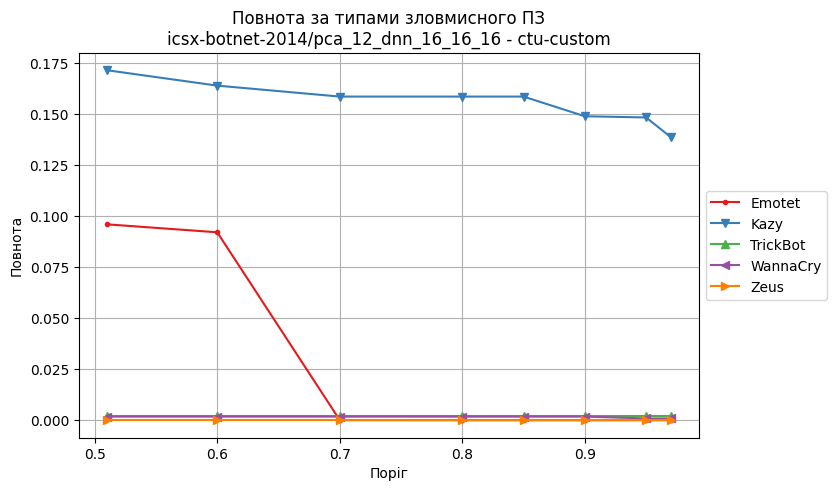

Model: icsx-botnet-2014/pca_12_dnn_24_24_24.keras
Recall per subclass
Data path: ./../flows/test/ctu-custom/malicious


,Threshold,Emotet,Kazy,TrickBot,WannaCry,Zeus
0,0.51,0.096,0.231,0.003,0.227,0.0
1,0.60,0.096,0.223,0.003,0.227,0.0
2,0.70,0.013,0.222,0.003,0.227,0.0
3,0.80,0.013,0.221,0.000,0.225,0.0
4,0.85,0.013,0.217,0.000,0.225,0.0
5,0.90,0.013,0.207,0.000,0.225,0.0
6,0.95,0.013,0.204,0.000,0.225,0.0
7,0.97,0.013,0.195,0.000,0.225,0.0


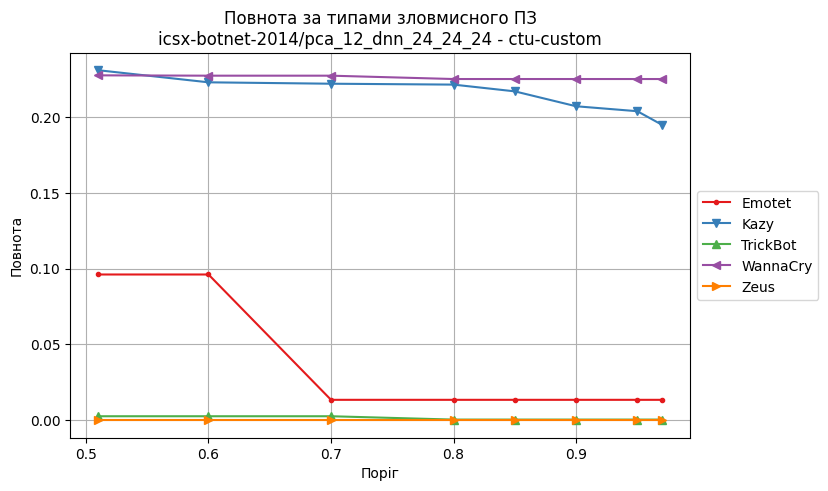

In [5]:
datasets = [
    "icsx-botnet-2014", "ctu-13", "ctu-custom"
]

models = [
    "icsx-botnet-2014/pca_12_log_reg.pkl", "icsx-botnet-2014/pca_12_rf_9.pkl",
    "icsx-botnet-2014/pca_12_dnn_16_16_16.keras", "icsx-botnet-2014/pca_12_dnn_24_24_24.keras"
]

for dataset in datasets:
    print("-----------------------------------------")
    print(f"  --->  Dataset: {dataset} <---")
    print("-----------------------------------------")

    evaluate(models, dataset, thresholds, plot=True, evaluate_per_subclass=True)

-----------------------------------------
  --->  Dataset: icsx-ctu-extended <---
-----------------------------------------
Model: icsx-botnet-2014/pca_12_log_reg.pkl
Recall per subclass
Data path: ./../flows/test/icsx-ctu-extended/malicious


,Threshold,DonBot,Emotet,IRC,Kazy,Menti,Murlo,Neris,NSIS.ay,RBot,Sogou,TrickBot,Virut,WannaCry,Weasel,Zeus
0,0.51,0.917,0.0,0.152,0.453,0.917,0.214,0.740,0.219,0.880,0.275,0.074,0.906,0.005,0.138,0.0
1,0.60,0.910,0.0,0.124,0.438,0.910,0.214,0.735,0.176,0.878,0.250,0.002,0.905,0.001,0.138,0.0
2,0.70,0.908,0.0,0.008,0.330,0.908,0.211,0.726,0.151,0.877,0.225,0.002,0.901,0.001,0.137,0.0
3,0.80,0.901,0.0,0.008,0.322,0.901,0.171,0.712,0.086,0.816,0.175,0.002,0.895,0.001,0.003,0.0
4,0.85,0.898,0.0,0.008,0.235,0.898,0.074,0.704,0.057,0.816,0.125,0.002,0.892,0.001,0.003,0.0
5,0.90,0.897,0.0,0.008,0.135,0.897,0.051,0.690,0.030,0.815,0.075,0.002,0.884,0.001,0.003,0.0
6,0.95,0.264,0.0,0.008,0.134,0.264,0.041,0.341,0.016,0.815,0.000,0.002,0.869,0.000,0.000,0.0
7,0.97,0.262,0.0,0.008,0.134,0.262,0.037,0.340,0.011,0.809,0.000,0.000,0.866,0.000,0.000,0.0


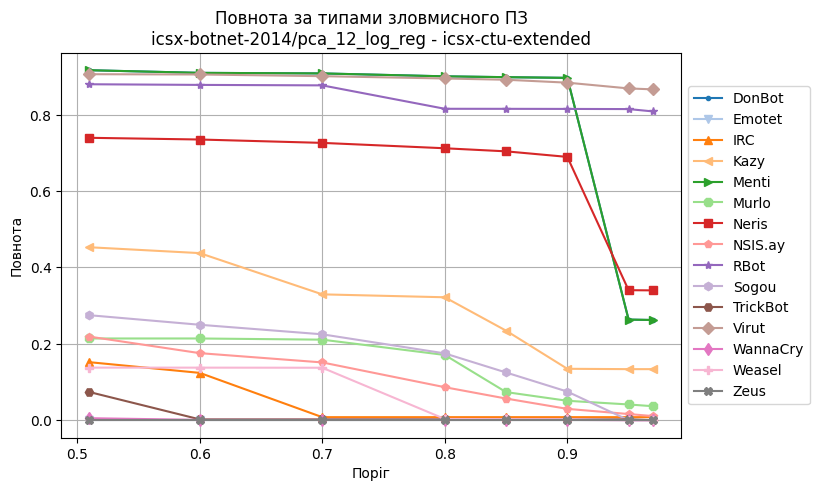

Data path: ./../flows/test/icsx-ctu-extended/malicious_extra


,Threshold,Black_hole,TBot,Zero_access,Zeus
0,0.51,0.062,0.025,0.0,0.239
1,0.60,0.062,0.014,0.0,0.103
2,0.70,0.053,0.010,0.0,0.070
3,0.80,0.044,0.010,0.0,0.023
4,0.85,0.044,0.000,0.0,0.023
5,0.90,0.044,0.000,0.0,0.023
6,0.95,0.009,0.000,0.0,0.000
7,0.97,0.009,0.000,0.0,0.000


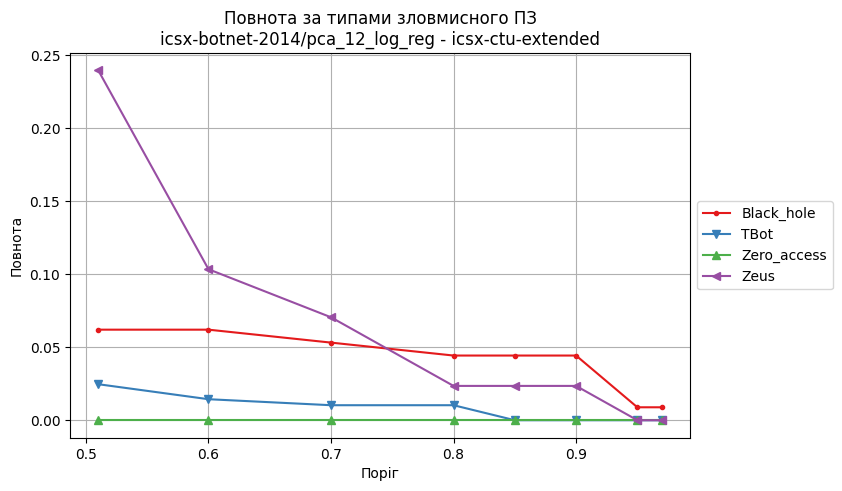

Model: icsx-botnet-2014/pca_12_rf_9.pkl
Recall per subclass
Data path: ./../flows/test/icsx-ctu-extended/malicious


,Threshold,DonBot,Emotet,IRC,Kazy,Menti,Murlo,Neris,NSIS.ay,RBot,Sogou,TrickBot,Virut,WannaCry,Weasel,Zeus
0,0.51,0.932,0.0,1.000,0.158,0.932,0.286,0.562,0.176,0.998,0.325,0.05,0.953,0.213,0.001,0.0
1,0.60,0.926,0.0,1.000,0.157,0.926,0.283,0.527,0.081,0.997,0.125,0.00,0.941,0.000,0.001,0.0
2,0.70,0.925,0.0,0.980,0.156,0.925,0.258,0.506,0.014,0.994,0.075,0.00,0.930,0.000,0.001,0.0
3,0.80,0.924,0.0,0.912,0.156,0.924,0.257,0.469,0.005,0.993,0.075,0.00,0.906,0.000,0.000,0.0
4,0.85,0.919,0.0,0.780,0.156,0.919,0.225,0.452,0.005,0.992,0.075,0.00,0.896,0.000,0.000,0.0
5,0.90,0.906,0.0,0.496,0.145,0.906,0.199,0.439,0.000,0.990,0.075,0.00,0.892,0.000,0.000,0.0
6,0.95,0.905,0.0,0.432,0.014,0.905,0.103,0.416,0.000,0.984,0.075,0.00,0.888,0.000,0.000,0.0
7,0.97,0.904,0.0,0.316,0.010,0.904,0.092,0.414,0.000,0.974,0.075,0.00,0.885,0.000,0.000,0.0


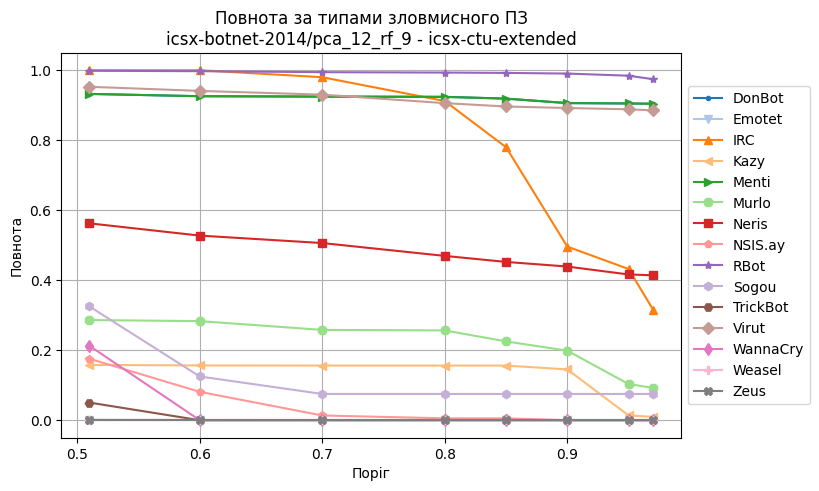

Data path: ./../flows/test/icsx-ctu-extended/malicious_extra


,Threshold,Black_hole,TBot,Zero_access,Zeus
0,0.51,0.124,0.016,0.0,0.117
1,0.60,0.000,0.014,0.0,0.085
2,0.70,0.000,0.000,0.0,0.005
3,0.80,0.000,0.000,0.0,0.000
4,0.85,0.000,0.000,0.0,0.000
5,0.90,0.000,0.000,0.0,0.000
6,0.95,0.000,0.000,0.0,0.000
7,0.97,0.000,0.000,0.0,0.000


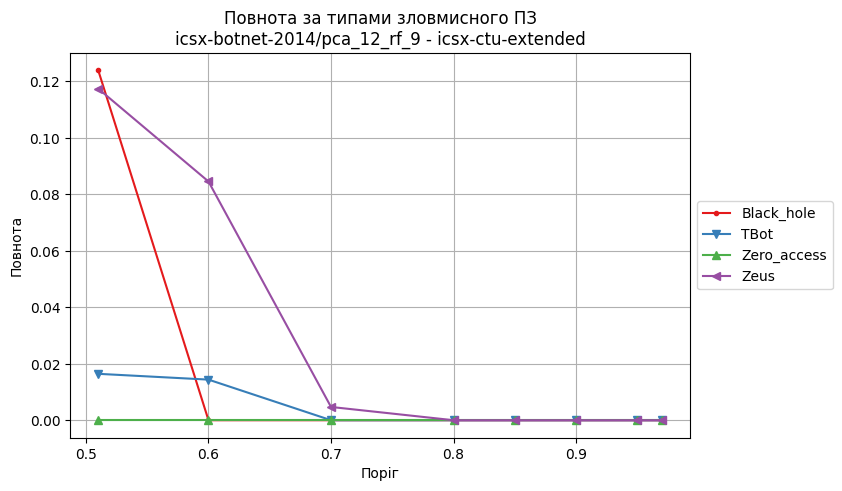

Model: icsx-botnet-2014/pca_12_dnn_16_16_16.keras
Recall per subclass
Data path: ./../flows/test/icsx-ctu-extended/malicious


,Threshold,DonBot,Emotet,IRC,Kazy,Menti,Murlo,Neris,NSIS.ay,RBot,Sogou,TrickBot,Virut,WannaCry,Weasel,Zeus
0,0.51,0.996,0.096,1.000,0.172,0.996,0.994,0.646,0.716,0.914,0.825,0.002,0.990,0.002,0.009,0.0
1,0.60,0.996,0.092,1.000,0.164,0.996,0.992,0.629,0.686,0.914,0.625,0.002,0.987,0.002,0.008,0.0
2,0.70,0.996,0.000,1.000,0.159,0.996,0.973,0.607,0.635,0.913,0.550,0.002,0.978,0.002,0.008,0.0
3,0.80,0.945,0.000,0.992,0.159,0.945,0.890,0.566,0.405,0.896,0.325,0.002,0.957,0.002,0.008,0.0
4,0.85,0.944,0.000,0.992,0.159,0.944,0.890,0.537,0.270,0.881,0.250,0.002,0.941,0.002,0.001,0.0
5,0.90,0.944,0.000,0.992,0.149,0.944,0.886,0.506,0.181,0.880,0.225,0.002,0.921,0.002,0.001,0.0
6,0.95,0.944,0.000,0.908,0.148,0.944,0.502,0.482,0.111,0.879,0.175,0.002,0.911,0.001,0.001,0.0
7,0.97,0.944,0.000,0.604,0.139,0.944,0.501,0.460,0.076,0.878,0.150,0.002,0.903,0.001,0.001,0.0


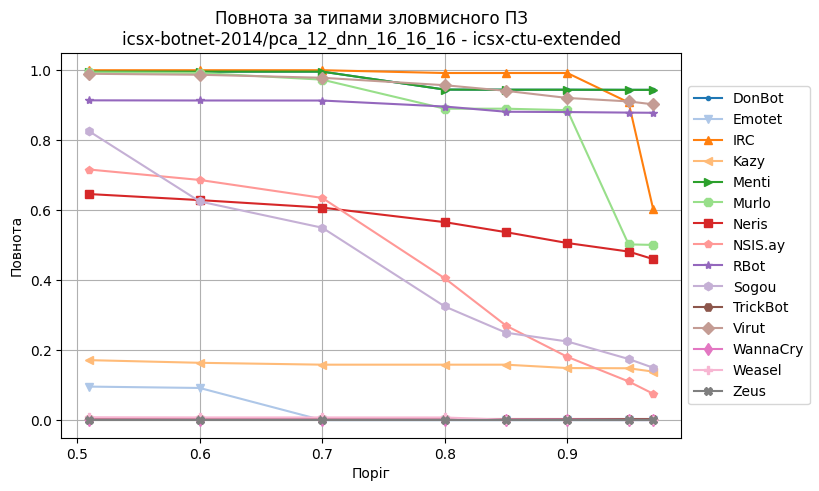

Data path: ./../flows/test/icsx-ctu-extended/malicious_extra


,Threshold,Black_hole,TBot,Zero_access,Zeus
0,0.51,0.0,0.021,0.0,0.108
1,0.60,0.0,0.021,0.0,0.103
2,0.70,0.0,0.006,0.0,0.070
3,0.80,0.0,0.004,0.0,0.009
4,0.85,0.0,0.004,0.0,0.009
5,0.90,0.0,0.004,0.0,0.009
6,0.95,0.0,0.000,0.0,0.005
7,0.97,0.0,0.000,0.0,0.005


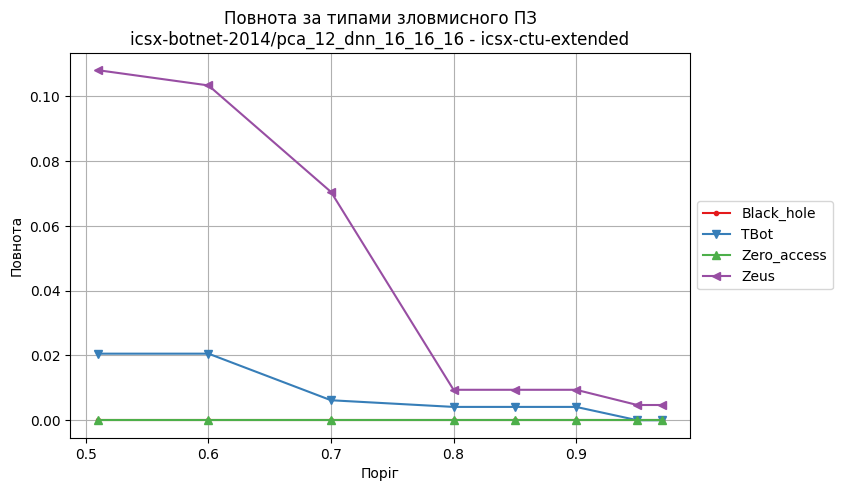

Model: icsx-botnet-2014/pca_12_dnn_24_24_24.keras
Recall per subclass
Data path: ./../flows/test/icsx-ctu-extended/malicious


,Threshold,DonBot,Emotet,IRC,Kazy,Menti,Murlo,Neris,NSIS.ay,RBot,Sogou,TrickBot,Virut,WannaCry,Weasel,Zeus
0,0.51,0.933,0.096,1.000,0.231,0.933,0.952,0.602,0.551,0.914,0.675,0.003,0.977,0.227,0.015,0.0
1,0.60,0.933,0.096,1.000,0.223,0.933,0.950,0.584,0.408,0.913,0.575,0.003,0.964,0.227,0.015,0.0
2,0.70,0.916,0.013,1.000,0.222,0.916,0.890,0.556,0.297,0.888,0.500,0.003,0.946,0.227,0.014,0.0
3,0.80,0.915,0.013,1.000,0.221,0.915,0.638,0.529,0.208,0.881,0.425,0.000,0.937,0.225,0.010,0.0
4,0.85,0.915,0.013,1.000,0.217,0.915,0.595,0.507,0.170,0.881,0.400,0.000,0.929,0.225,0.010,0.0
5,0.90,0.914,0.013,1.000,0.207,0.914,0.502,0.487,0.122,0.880,0.300,0.000,0.917,0.225,0.009,0.0
6,0.95,0.906,0.013,0.988,0.204,0.906,0.128,0.468,0.081,0.879,0.225,0.000,0.901,0.225,0.003,0.0
7,0.97,0.906,0.013,0.964,0.195,0.906,0.128,0.455,0.068,0.872,0.225,0.000,0.894,0.225,0.003,0.0


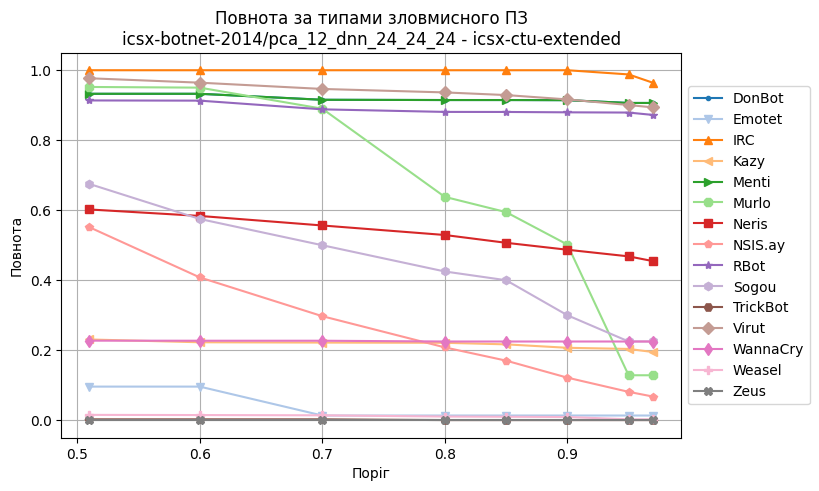

Data path: ./../flows/test/icsx-ctu-extended/malicious_extra


,Threshold,Black_hole,TBot,Zero_access,Zeus
0,0.51,0.009,0.027,0.0,0.047
1,0.60,0.009,0.027,0.0,0.042
2,0.70,0.009,0.012,0.0,0.038
3,0.80,0.009,0.012,0.0,0.038
4,0.85,0.009,0.010,0.0,0.033
5,0.90,0.009,0.010,0.0,0.023
6,0.95,0.009,0.004,0.0,0.014
7,0.97,0.009,0.004,0.0,0.014


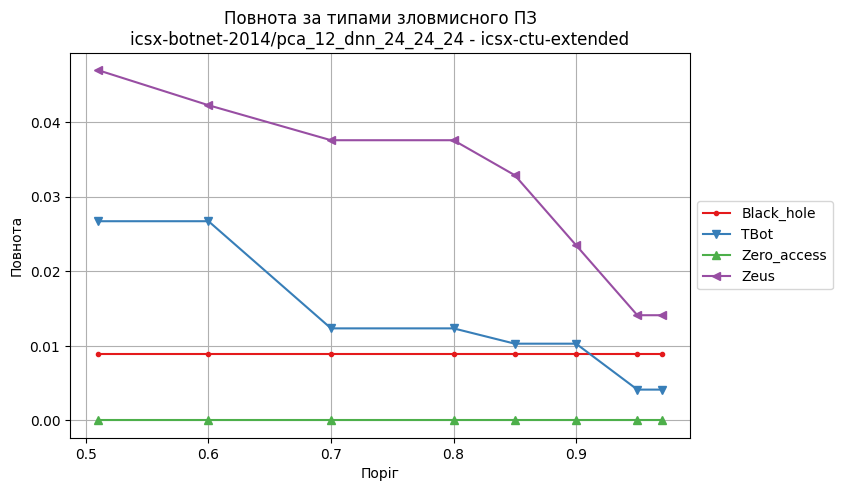

In [6]:
datasets = [
    "icsx-ctu-extended"
]

models = [
    "icsx-botnet-2014/pca_12_log_reg.pkl", "icsx-botnet-2014/pca_12_rf_9.pkl",
    "icsx-botnet-2014/pca_12_dnn_16_16_16.keras", "icsx-botnet-2014/pca_12_dnn_24_24_24.keras"
]

for dataset in datasets:
    print("-----------------------------------------")
    print(f"  --->  Dataset: {dataset} <---")
    print("-----------------------------------------")

    evaluate(models, dataset, thresholds, plot=True, evaluate_per_subclass=True)